In [10]:
import os, sys

ROOT_DIR = os.path.abspath("..")
if ROOT_DIR not in sys.path:
    sys.path.insert(0, ROOT_DIR)

print("Using project root:", ROOT_DIR)


Using project root: C:\Users\laksh\microstructure-project


Found 36 voxel files for feature 'DistanceFrom'.
Dataset sample shape (C,D,H,W): torch.Size([1, 128, 128, 128])
Batch volume shape (B,C,D,H,W): torch.Size([1, 1, 128, 128, 128])


C:\Users\laksh\AppData\Local\Temp\ipykernel_9948\2421207483.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(WEIGHTS, map_location="cpu")


orig_vol shape: (128, 128, 128)
recon_vol shape: (128, 128, 128)
orig_slice shape: (128, 128)
recon_slice shape: (128, 128)


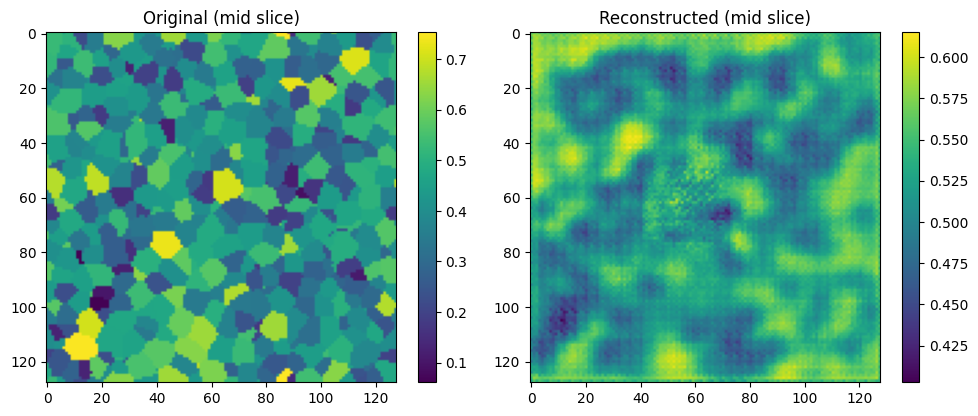

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from src.dataset import VoxelHDF5Dataset
from src.models.cnn3d_ae import MicrostructureAE3D


# --- config ---
BASE_VOXEL_DIR = "C:/Users/laksh/microstructure-project/data/raw/ss75fdg5dg-1/FCC_voxelwise"
FEATURE_KEY = "DistanceFrom"
GRID_SIZE = 128
WEIGHTS = "C:/Users/laksh/microstructure-project/data/processed/ae_DistanceFrom_epoch20.pt"  

# --- dataset & one sample ---
ds = VoxelHDF5Dataset(
    base_dir=BASE_VOXEL_DIR,
    feature_key=FEATURE_KEY,
    grid_size=GRID_SIZE,
)
vol = ds[0]                      # (C, D, H, W)
print("Dataset sample shape (C,D,H,W):", vol.shape)

vol = vol.unsqueeze(0)           # (1, C, D, H, W)
print("Batch volume shape (B,C,D,H,W):", vol.shape)

#  model 
in_channels = vol.shape[1]
model = MicrostructureAE3D(
    in_channels=in_channels,
    latent_dim=4096,
)
state = torch.load(WEIGHTS, map_location="cpu")
model.load_state_dict(state)
model.eval()

with torch.no_grad():
    recon, z = model(vol)

# --- numpy volumes, single channel ---
orig_vol = vol[0, 0].numpy()      # (128,128,128)
recon_vol = recon[0, 0].numpy()   # (128,128,128)

print("orig_vol shape:", orig_vol.shape)
print("recon_vol shape:", recon_vol.shape)

mid = orig_vol.shape[0] // 2

orig_slice = orig_vol[mid, :, :]
recon_slice = recon_vol[mid, :, :]

print("orig_slice shape:", orig_slice.shape)
print("recon_slice shape:", recon_slice.shape)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(orig_slice, cmap="viridis")
plt.title("Original (mid slice)")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(recon_slice, cmap="viridis")
plt.title("Reconstructed (mid slice)")
plt.colorbar()

plt.tight_layout()
plt.savefig("C:/Users/laksh/microstructure-project/results/figures/ae_reconstruction_slice.png", dpi=300)
plt.show()